# **Модуль Б**. Разработка модели машинного обучения

## Импортирование библиотек

In [ ]:
# модули для работы с моделью
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd

from IPython.display import Audio

from Model.tokenizer import Tokenizer

import numpy as np

from IPython.display import Audio

import librosa
import librosa.display
import matplotlib.pyplot as plt

import math

from tqdm import tqdm  # Импортируем tqdm


## Загрузка данных

In [69]:
# путь к обработанным данным
data_path = '../Module1/Dataset/dataset.h5'
# загружаем датасета
df = pd.read_hdf(data_path, key='df')
df.head()

,token_ids,mel_spec
0,"[25, 8, 25, 4, 3, 8, 5, 13, 3, 15, 10, 3, 11, ...","[[-56.18891, -54.528297, -43.84198, -44.330162..."
1,"[21, 9, 8, 12, 25, 20, 3, 12, 2, 24, 12, 25, 3...","[[-55.704872, -55.704872, -55.704872, -55.7048..."
2,"[22, 28, 10, 13, 25, 11, 0, 3, 15, 23, 18, 15,...","[[-57.897354, -57.897354, -51.308334, -54.8423..."
3,"[14, 11, 9, 3, 15, 2, 11, 5, 3, 22, 13, 9, 19,...","[[-59.127876, -59.127876, -55.668625, -55.1438..."
4,"[12, 19, 25, 28, 6, 25, 11, 3, 21, 9, 32, 2, 1...","[[-50.631554, -50.631554, -50.631554, -50.6315..."


## **Класс с датасетом**

In [229]:
# класс для датасета
class TTSDataset(Dataset):
    # конструктор класса
    def __init__(self, data_path):
        '''data_path - путь к данным в формате h5'''
        # получаем датафрейм
        self.data = pd.read_hdf(data_path, key='df')
        # получаем списки с токенами и мел-спектрограммами
        self.mels = self.data['mel_spec']
        self.token_ids = self.data['token_ids']

    # метод для получения длины датасета
    def __len__(self):
        return len(self.token_ids)
    
    # метод получения элемента
    def __getitem__(self, idx):
        # возвращаем тензоры
        token_ids = torch.LongTensor(self.token_ids[idx])
        mel = torch.FloatTensor(self.mels[idx])

        return token_ids, mel

In [231]:
dataset = TTSDataset(data_path)
dataset[0]

(tensor([25,  8, 25,  4,  3,  8,  5, 13,  3, 15, 10,  3, 11,  2, 13,  0, 12,  2,
          3, 11, 25, 13, 25, 15, 11, 13,  9, 19,  5, 26,  3, 32,  2, 14, 11,  2,
         26,  3, 15,  2,  3,  9,  3, 23, 29, 10, 15,  5, 26, 34, 34, 34, 34, 34,
         34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
         34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
         34, 34, 34, 34, 34, 34, 34, 34, 34]),
 tensor([[-56.1889, -54.5283, -43.8420,  ..., -80.0000, -80.0000, -80.0000],
         [-56.1889, -52.8671, -39.4327,  ..., -80.0000, -80.0000, -80.0000],
         [-56.1889, -52.7999, -34.5382,  ..., -80.0000, -80.0000, -80.0000],
         ...,
         [-56.1889, -56.1889, -56.1889,  ..., -80.0000, -80.0000, -80.0000],
         [-56.1889, -56.1889, -56.1889,  ..., -80.0000, -80.0000, -80.0000],
         [-56.1889, -56.1889, -56.1889,  ..., -80.0000, -80.0000, -80.0000]]))

In [235]:
PAD_IDX = 34

In [236]:
# Проверяем один пример
tokens, mel = dataset[0]
print("Пример 0:")
print(f"Токены: {tokens} (длина: {len(tokens)})")
print(f"Спектрограмма: {mel.shape}")

Пример 0:
Токены: tensor([25,  8, 25,  4,  3,  8,  5, 13,  3, 15, 10,  3, 11,  2, 13,  0, 12,  2,
         3, 11, 25, 13, 25, 15, 11, 13,  9, 19,  5, 26,  3, 32,  2, 14, 11,  2,
        26,  3, 15,  2,  3,  9,  3, 23, 29, 10, 15,  5, 26, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34]) (длина: 99)
Спектрограмма: torch.Size([80, 498])


In [250]:
dataloader = DataLoader(dataset, shuffle=True, batch_size=16)

In [251]:
# Проверяем батч
for batch_idx, (tokens_batch, mels_batch) in enumerate(dataloader):
    print(f"\nБатч {batch_idx}:")
    print(f"Токены: {tokens_batch.shape}")
    print(f"Спектрограммы: {mels_batch.shape}")
    break


Батч 0:
Токены: torch.Size([16, 99])
Спектрограммы: torch.Size([16, 80, 498])


In [243]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [248]:
# Параметры
tokenizer = Tokenizer()
vocab_size = tokenizer.getlen()      # пример размера словаря
print(f'vocab_size: {vocab_size}')
n_mels = 80           # число мел-коэффициентов
T_text = 99           # длина текстовой последовательности
T_mel = 498           # временная длина мел-спектрограммы


/home/user/Chemp/Speech-synthesis/Module2
vocab_size: 35


## **Класс с моделью**

**1. Text Encoder**

In [260]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, hidden_dim, n_layers=4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.convs = nn.Sequential(
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=1),
            nn.ReLU()
        )
        self.lstm = nn.LSTM(hidden_dim, hidden_dim//2, n_layers, 
                           bidirectional=True, batch_first=True)

    def forward(self, x):
        x = self.embedding(x)  # [B, T] -> [B, T, D]
        x = x.transpose(1, 2)  # [B, D, T]
        x = self.convs(x)
        x = x.transpose(1, 2)  # [B, T, D]
        x, _ = self.lstm(x)
        return x

In [261]:
class DurationPredictor(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(hidden_dim, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Conv1d(hidden_dim, 1, 1)
        )

    def forward(self, x):
        return self.net(x.transpose(1, 2)).squeeze(1)  # [B, T]

In [262]:
class MelDecoder(nn.Module):
    def __init__(self, hidden_dim, n_mels):
        super().__init__()
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, 2, batch_first=True)
        self.proj = nn.Linear(hidden_dim, n_mels)

    def forward(self, x):
        x, _ = self.lstm(x)  # [B, T, D]
        return self.proj(x)   # [B, T, n_mels]

In [264]:
class SimpleVITS(nn.Module):
    def __init__(self, vocab_size, n_mels=80, hidden_dim=256):
        super().__init__()
        self.text_encoder = TextEncoder(vocab_size, hidden_dim)
        self.duration_predictor = DurationPredictor(hidden_dim)
        self.mel_decoder = MelDecoder(hidden_dim, n_mels)
        
    def forward(self, tokens, mels=None):
        # Кодирование текста
        text_enc = self.text_encoder(tokens)  # [B, T_text, D]
        
        # Предсказание длительностей
        log_dur = self.duration_predictor(text_enc)  # [B, T_text]
        dur = torch.exp(log_dur).round().long()
        
        # Расширение по длительностям
        x = self.length_regulator(text_enc, dur)  # [B, T_mel, D]
        
        # Декодирование в мел-спектрограмму
        mel = self.mel_decoder(x)  # [B, T_mel, n_mels]
        return mel.transpose(1, 2), log_dur  # [B, n_mels, T_mel]

    def length_regulator(self, x, dur):
        """Повторяем каждый элемент согласно предсказанной длительности"""
        out = []
        for i in range(x.size(0)):
            out.append(torch.repeat_interleave(x[i], dur[i], dim=0))
        return nn.utils.rnn.pad_sequence(out, batch_first=True)

In [265]:
# Инициализация
model = SimpleVITS(vocab_size=35, n_mels=80, hidden_dim=256)

# Пример входа (токенизированный текст)
tokens = torch.randint(0, 100, (2, 10))  # [batch_size, seq_len]

# Forward pass
mels, log_dur = model(tokens)
print(mels.shape)  # [2, 80, T_mel]

IndexError: index out of range in self

In [90]:
# Получаем предсказанные мел-спектрограммы от модели
model.eval()
with torch.no_grad():
    pred_mel= model(text.to(device))  # Получаем предсказание из модели

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [87]:
print("Durations:", durations)  # <- Какие значения предсказаны?
print("Sum durations:", durations.sum())

Durations: tensor([[ 0.0903,  0.1116, -0.0426,  0.0020, -0.0756,  0.0899, -0.1463,  0.1203,
         -0.0994, -0.0278,  0.0268,  0.0310, -0.0941, -0.0210,  0.1243,  0.0570,
         -0.0195,  0.1060,  0.0085, -0.0171,  0.0606,  0.0848, -0.0062,  0.0703,
         -0.0117,  0.1089,  0.0516,  0.0569, -0.0910,  0.0371, -0.0297, -0.0224,
          0.0496,  0.0150,  0.0141,  0.0280,  0.0906,  0.0542, -0.0161,  0.0381,
          0.1475, -0.0006,  0.0961,  0.0710,  0.1184,  0.0585,  0.1095,  0.0923,
          0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,
          0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,
          0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,
          0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,
          0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,
          0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,  0.0685,
          0.0685,

In [88]:
pred_mel.shape

torch.Size([1, 80, 99])

In [89]:
pred_mels_np = pred_mel.detach().cpu().numpy()
print(pred_mels_np.shape)
pred_mels_np_T = pred_mels_np.squeeze(0).T 
pred_mels_np_T = torch.nn.functional.interpolate(
                pred_mel, size=mel_spectrograms[0].shape[-1], mode="linear", align_corners=False
            )
print(pred_mels_np_T.detach().cpu().numpy().shape)

(1, 80, 99)
(1, 80, 498)


In [90]:
y = invert_mel(pred_mels_np_T.detach().cpu().numpy())
y

array([[ 0.128308  ,  0.28800216,  0.06370329, ..., -0.06695668,
         0.32469797,  0.04823967]], dtype=float32)

In [91]:
y_target = invert_mel(df['mel_spec'][0])
y_target

array([-2.7501053e-05,  3.0485648e-04,  1.5856112e-04, ...,
       -1.6679214e-05, -1.0877101e-05,  3.1890292e-07], dtype=float32)

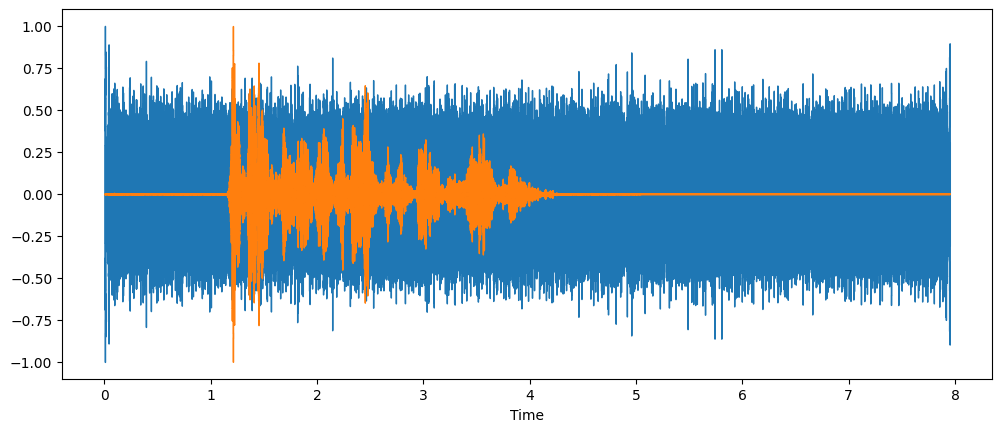

In [92]:
plt.figure().set_figwidth(12)
librosa.display.waveshow(y, sr=16000)
librosa.display.waveshow(y_target, sr=16000)

In [224]:
Audio(y, rate=16000)

In [29]:
import soundfile as sf
sf.write('output6.wav', y, 16000)  # Транспонируем для soundfile

In [167]:
torch.save(model.state_dict(), 'tts_model_words1.pth')  # Только веса
# ИЛИ
torch.save(model, 'tts_model_full_word1.pt')  # Веса + архитектура

In [ ]:
# Для state_dict
model = TTSTransformer(vocab_size, d_model=256, n_mels=80)
model.load_state_dict(torch.load('tts_model.pth'))
model.eval()

# Для полной модели
model = torch.load('tts_model_full.pt')
model.eval()

In [150]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
cosine_similarity(y.reshape(-1, 1), df['array'][0].reshape(-1, 1))